# Example MANGA cube queries
For the cube data, we have loaded two formats:

* **per-spaxel**: One row per spaxel, where each wavelength-indexed field is represented as an array and each per pixel sumary stat is a scalar, headers are repeated by the number of spectrum-holding pixels in the cube.
* **per-voxel**: One row per voxel, where each wavelentth-indexed field is a scalar, and summary stats are repeated the length of the spectral axis, headers are repeated by the number of spectrum-holding pixels AND the length of spectral axis.

Each format is more natural for certain types of queries - some examples shown below. The loading is simpler for the spaxel case and a bit more overhead for the voxel case, but the storage requirements are effectively the same due to the internal structure of the Parquet format. See loading notebook for more details on writing and storage requirements.

Below I compare queries in both runtime and expression, and attempt to demonstrate potential science use-cases but not in a rigurous manner. The runtimes are meant for rough comparison only, not as benchmarks.

### Notebook setup

In [176]:
%%configure -f
{"name": "arik-query-logcube-x", "executorMemory": "4G", "numExecutors": 32, "executorCores": 4,
 "conf": {"spark.yarn.appMasterEnv.PYSPARK_PYTHON":"python3"}}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
74,application_1586890731024_0070,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
70,application_1586890731024_0066,pyspark,killed,Link,,
74,application_1586890731024_0070,pyspark,idle,Link,Link,✔


In [177]:
import numpy as np
import matplotlib.pyplot as plt
import time

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [178]:
timer = 0
def ts():
    global timer
    timer = time.time()
def tt(msg='time'):
    global timer
    print('{}: {:0.2f}s'.format(msg, time.time()-timer))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Load data/declare tables

We are not really loading anything, just getting summary info from the files and creating metadata for SQL in our spark session.

In [179]:
ts()
data = spark.read.parquet('hdfs:///manga/arik-test/dr15/v2_4_3/logcube')
data.createOrReplaceTempView('perSpaxel')
tt('declaring perSpaxel')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

declaring perSpaxel: 6.18s

In [180]:
ts()
data = spark.read.parquet('hdfs:///manga/arik-test/dr15/v2_4_3/logcube_voxel')
data.createOrReplaceTempView('perVoxel')
tt('declaring perVoxel')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

declaring perVoxel: 3.42s

In [181]:
tables = ['perSpaxel', 'perVoxel']

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Queries
Below are example queries, where in each I repeat the query for **perSpaxel** data and **perVoxel**, respectively. 

### Count queries
These queries should be reading summary stats from the footer of files or metadata from row groups (parquet stores column data in sequential chunks called row groups). The data size and number of files is the same for the two tables, so I don't have a good explanation now why the counting is not more similar between the two. One explanation would be that the summary stats have not been written to the files.

In [194]:
for table in tables:
    ts()
    spark.sql('''SELECT count(*) FROM {}'''.format(table)).show()
    tt(table)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+
|count(1)|
+--------+
|10179808|
+--------+

perSpaxel: 8.07s
+-----------+
|   count(1)|
+-----------+
|46450463904|
+-----------+

perVoxel: 19.18s

### Recreating broadband images for a set of objects
We subselect by mangaid and get the G broadband value. In both cases we use the \_src position fields which record the origin X and Y position of the spaxel in the cube. In the perSpaxel case, this is one scalar per (X,Y) per mangaid, while in the perVoxel case this value is repeated by ~4000x (spectral axis length) and we have to use aggregation to get one value from it.

This would not be a primary use-case for a catalog like this, but does show that it can serve a general purpose and do so in a fairly straightforward manner.

First we get a handful of random mangaids, then find the source positions and G band flux.

In [195]:
for table in tables:
    ts()
    mangaids = spark.sql('''SELECT distinct(mangaid) mangaid FROM {} LIMIT 10'''.format(table)).toPandas()
    tt(table)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

perSpaxel: 21.97s
perVoxel: 118.64s

For the perSpaxel table this is straightforward:

In [196]:
ts()
g_perspaxel = spark.sql('''
SELECT MANGAID, _SRC_X, _SRC_Y, G FROM perSpaxel WHERE MANGAID IN {}
'''.format(tuple(mangaids['mangaid']))).toPandas()
tt('perSpaxel')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

perSpaxel: 6.60s

For the perVoxel, we have to aggregate. Even though the on-disk format here is most likely using run-length-encoding to essentially store one value (ish) for each of the 4000+ wavelength indexed rows, the code still needs to unroll it before applying the `first` aggregation (*is there no optimization here?*):

In [197]:
ts()
g_pervoxel = spark.sql('''
SELECT MANGAID, first(G) as G, _SRC_X, _SRC_Y FROM perVoxel 
WHERE mangaid IN {} GROUP BY MANGAID, _SRC_X, _SRC_Y
'''.format(tuple(mangaids['mangaid']))).toPandas()
tt('perVoxel')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

perVoxel: 17.95s

Prove to ourselves they indeed do the same thing, lets plot some of the images

In [60]:
def reconstruct_g_img(data, mangaid):
    d = data[data['MANGAID'] == mangaid]
    shape = (d['_SRC_Y'].max()+1, d['_SRC_X'].max()+1)
    img = np.zeros(shape)
    img[d['_SRC_Y'], d['_SRC_X']] = d['G']
    return img

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [63]:
fig, axs = plt.subplots(2, 5, figsize=[22,8])
for ax, mangaid in zip(axs.ravel()[0:5], mangaids['mangaid'][0:5]):
    _ = ax.imshow(reconstruct_g_img(g_perspaxel, mangaid), aspect='auto')
for ax, mangaid in zip(axs.ravel()[5:10], mangaids['mangaid'][0:5]):
    _ = ax.imshow(reconstruct_g_img(g_pervoxel, mangaid), aspect='auto')
_ = plt.subplots_adjust(left=0.01, right=0.99)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In the figure below, we show reconstructed g-band images for the first five of the objects. The top row is the perSpaxel, and bottom perVoxel. They are the same of course

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

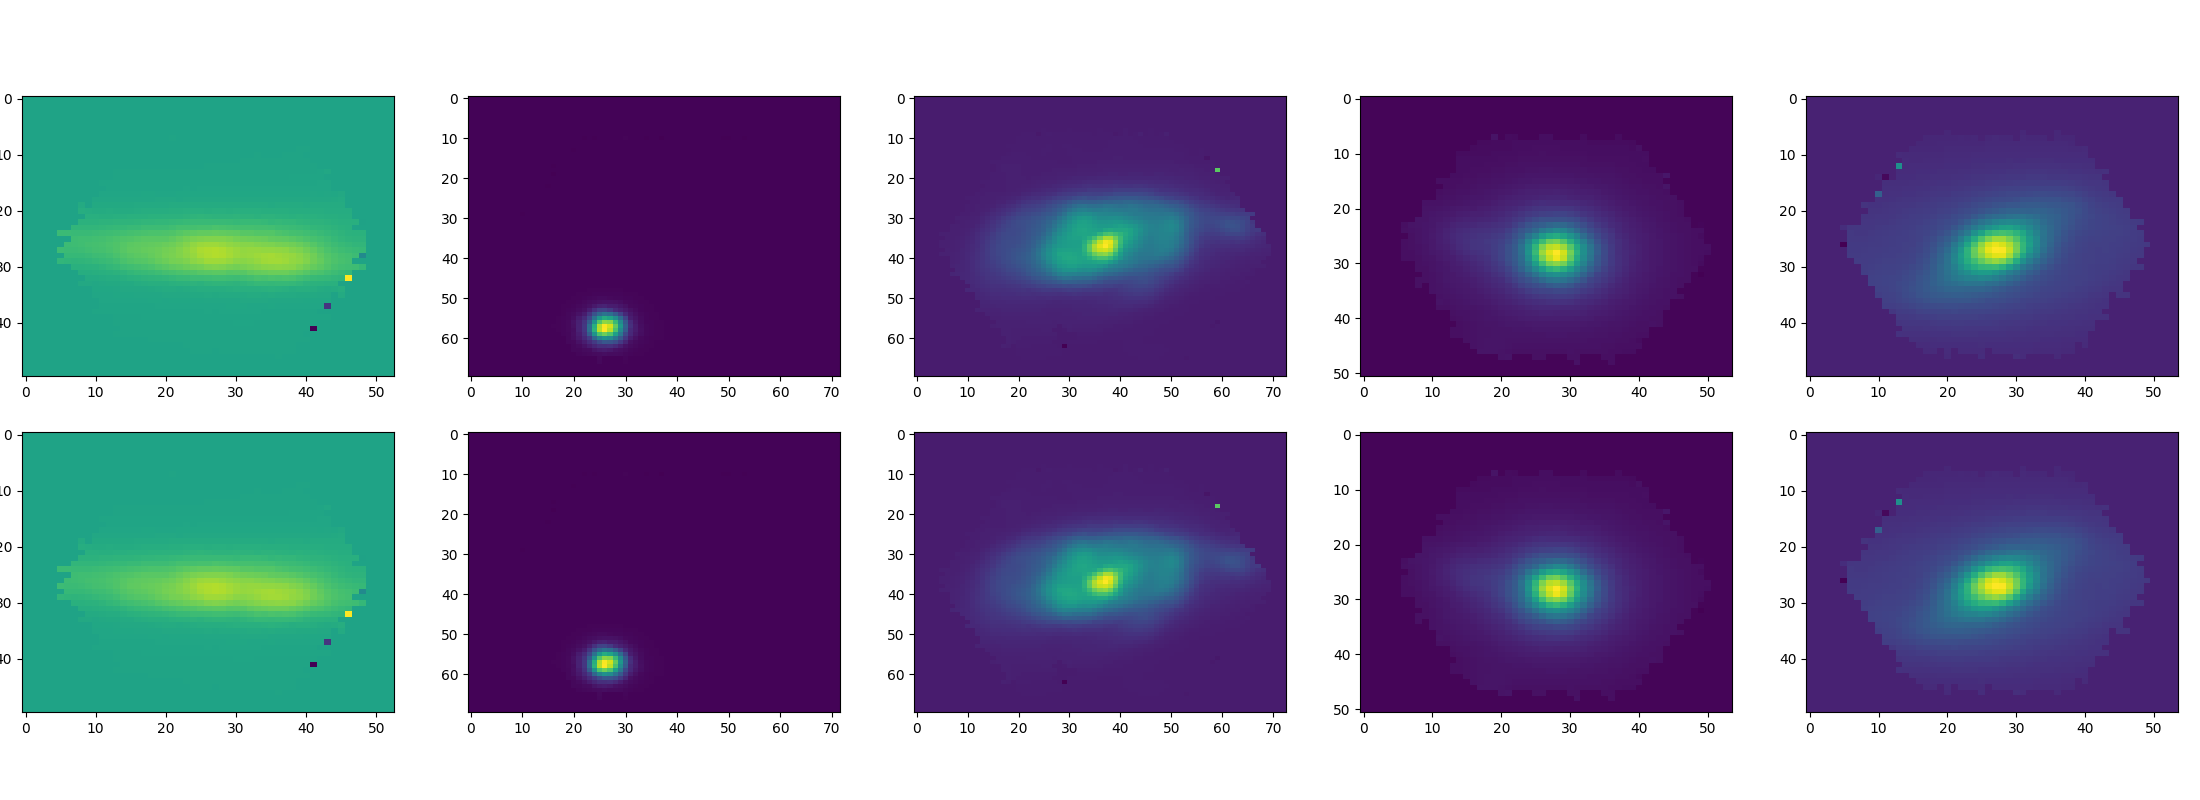

In [64]:
%matplot plt

### All sky flux
One might want to create a map of the flux over the whole catalog or in a particular region at a particular resolution, and possibly in a band or from a line fit. These queries demonstrate such an operation, at a simple level: sum of the flux of the whole spectrum in integer dergree bins.

These queries must scan through and aggregate the ra/dec and flux columns for all files in the catalog. The calculations in essence should be pretty much identical, given that they both first sum each spectrum in a spaxel and then sum the per-spaxel total flux - and the layout on disk is almost identical between these two layouts for the `FLUX` column.

The seemingly higher efficiency for the perSpaxel case might be explained by optimizations in spark for array data types, whereas the grouping code for the perVoxel case incurs some overhead.

In [198]:
ts()
flux_ra_dec_perspaxel = spark.sql('''
SELECT RA, DEC, sum(TOT_FLUX) FLUX FROM (
  SELECT CAST(RA as INT), CAST(DEC as INT), aggregate(FLUX, double(0.0), (a, x) -> a+x) as TOT_FLUX FROM perSpaxel)
GROUP BY RA, DEC
''').toPandas()
tt('perSpaxel')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

perSpaxel: 239.21s

You can note that the SQL expression for the perVoxel case is simpler:

In [199]:
ts()
flux_ra_dec_pervoxel = spark.sql('''
SELECT RA, DEC, sum(TOT_FLUX) FLUX FROM (
  SELECT CAST(RA as INT), CAST(DEC as INT), SUM(FLUX) AS TOT_FLUX FROM perVoxel GROUP BY RA, DEC)
GROUP BY RA, DEC
''').toPandas()
tt('perVoxel')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

perVoxel: 286.70s

Let's convince ourselves that the result is the same, and make a pretty picture at the same time!

In [83]:
flux_ra_dec_perspaxel = flux_ra_dec
f = plt.figure(figsize=[12,6])
for sp, dat, case in zip([121, 122], [flux_ra_dec_perspaxel, flux_ra_dec_pervoxel], tables):
    ax = f.add_subplot(sp, projection='lambert')
    ra_ = dat['RA']/180*np.pi - np.pi
    dec_ = dat['DEC']/90*np.pi/2
    plt.grid(True)
    ax.set_title('All sky total flux ({})'.format(case))
    ax.hexbin(ra_, dec_, C=dat['FLUX'], cmap='hsv')
_ = plt.subplots_adjust(left=0.01, right=0.99, top=0.98, bottom=0.05)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

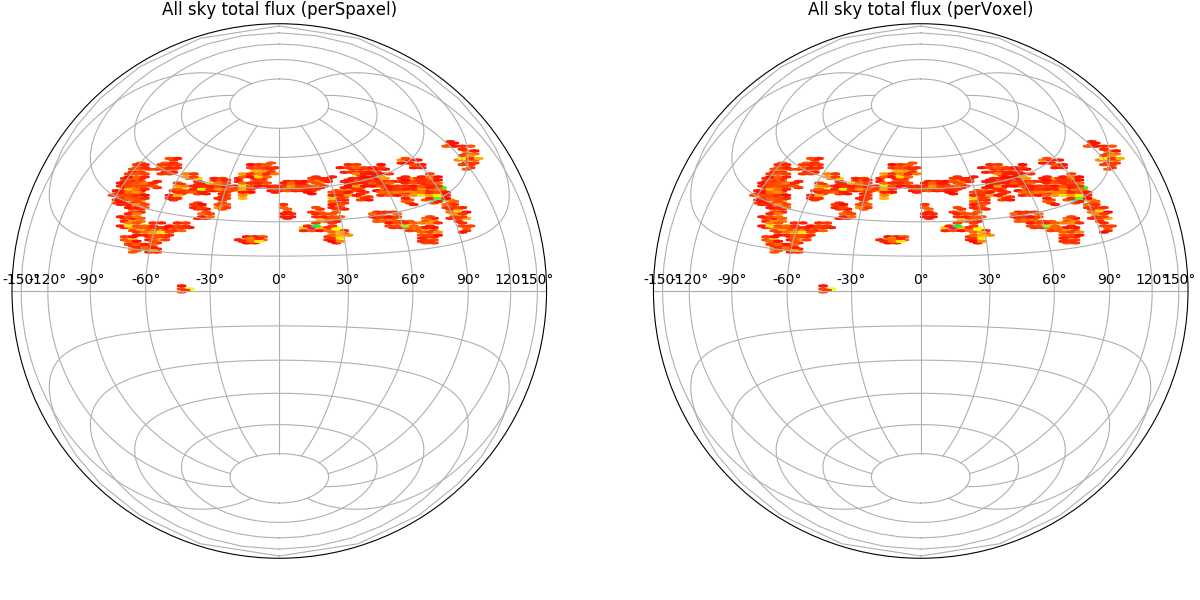

In [84]:
%matplot plt

Yeah, close enough

### Mean spectrum
Now we compute the mean spectrum across the entire catalog. Spark does not have a straightforward way to aggregate *across* arrays by row, so for the perSpaxel case we use the explode (essentially a transposition followed by a join) functionality. The perVoxel case is quit a bit more straightforward, since the format is essentially already exploded.

There is a detail here: grouping by WAVE, essentially assumes the wavelength solution is unique across the entire catalog. If this were the case, storing it in the catalog could be avoided alogether by keeping it at the software side. UDFs might be used to operate on the FLUX and other arrays by WL. If not, then we would need rebinning to happen prior to grouping.

In [200]:
ts()
meanspec_perspaxel = spark.sql('''
SELECT SPEC.WAVE AS WAVE, AVG(SPEC.FLUX) AS FLUX FROM (
  SELECT explode_outer(arrays_zip(WAVE, FLUX)) AS SPEC FROM perSpaxel
) GROUP BY SPEC.WAVE ORDER BY SPEC.WAVE ASC
''').toPandas()
tt('perSpaxel')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

perSpaxel: 575.17s

In [201]:
ts()
meanspec_pervoxel = spark.sql('''
SELECT WAVE, AVG(FLUX) AS FLUX FROM perVoxel GROUP BY WAVE ORDER BY WAVE ASC
''').toPandas()
tt('perVoxel')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

perVoxel: 360.97s

Here we see the first real benefit of the perVoxel layout in our test cases. This is due to the overhead in the explode operation. The perVoxel query is much more succinct.

Now we convince ourselves the result is the same:

In [115]:
f, ax = plt.subplots(3, 1, figsize=[16,5], sharex=True)
ax[0].plot(meanspec_perspaxel['WAVE'], meanspec_perspaxel['FLUX'])
ax[1].plot(meanspec_pervoxel['WAVE'], meanspec_pervoxel['FLUX'])
ax[2].plot(meanspec_pervoxel['WAVE'], meanspec_perspaxel['FLUX'] - meanspec_pervoxel['FLUX'])
_ = ax[0].set_title('mean spectrum')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

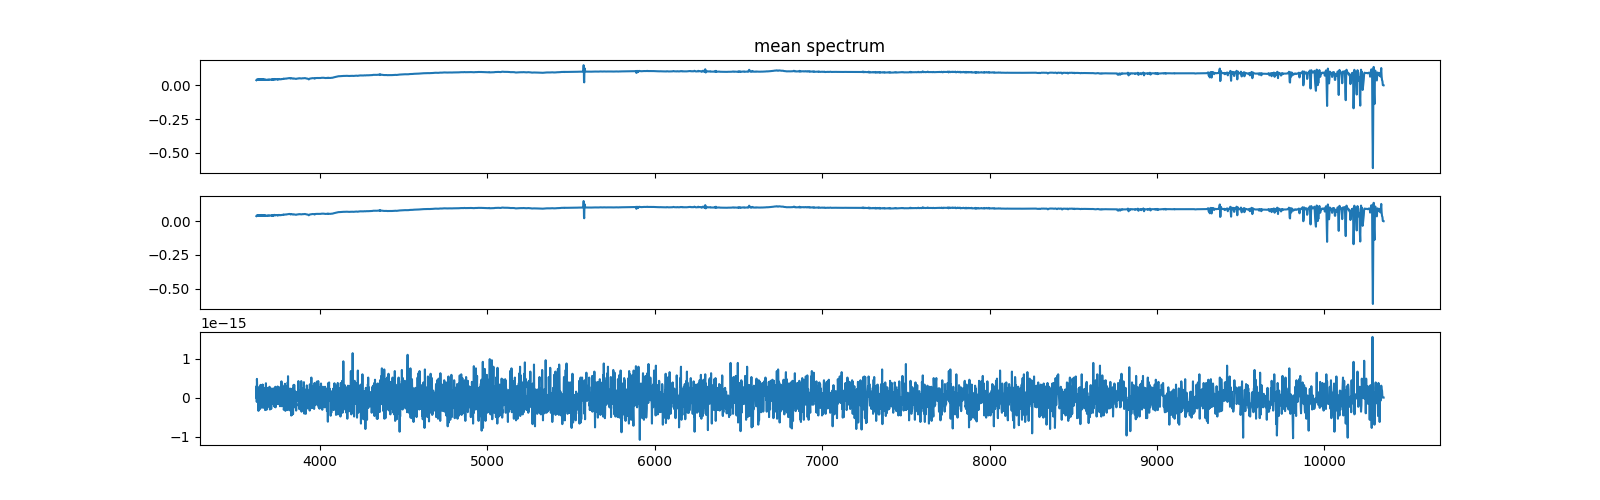

In [116]:
%matplot plt

Note that the difference between the two is at with ~1e-15 and probably comes from error in floating point calculations.

### Sum of flux within band
This query also touches all objects and in the case of perSpaxel all rows. For perVoxel it most likely at least scans the whole WAVE column but must pull in less data to memory. The times are not substantially different than the mean spectrum case above.

In [182]:
ts()
bandflux_perspaxel = spark.sql('''
SELECT MANGAID, SUM(SPEC.FLUX) AS BAND_FLUX FROM (
  SELECT MANGAID, explode_outer(arrays_zip(WAVE, FLUX)) AS SPEC FROM perSpaxel
) WHERE SPEC.WAVE BETWEEN 5570 AND 5590 GROUP BY MANGAID
''').toPandas()
tt('perSpaxel')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

perSpaxel: 507.23s

In [187]:
ts()
bandflux_pervoxel = spark.sql('''
SELECT MANGAID, sum(FLUX) AS BAND_FLUX FROM perVoxel WHERE WAVE BETWEEN 5570 AND 5590 GROUP BY MANGAID
''').toPandas()
tt('perVoxel')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

perVoxel: 308.16s

In [188]:
plt.figure(figsize=[10,4])
_ = plt.hist(bandflux_perspaxel['BAND_FLUX'], log=True)
_ = plt.hist(bandflux_pervoxel['BAND_FLUX'], log=True, histtype='step')
_ = plt.legend(reversed(tables))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

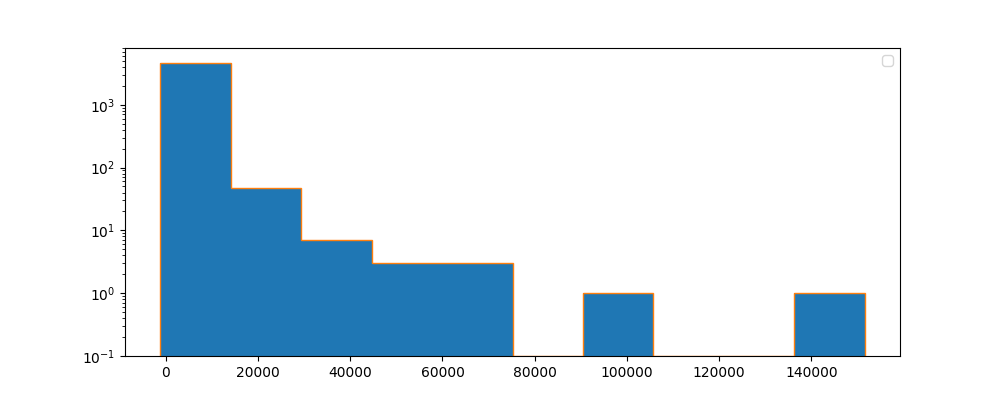

In [189]:
%matplot plt

Similar to what is mentioned in the previous section, for the perSpaxel case the exploding operation here could possibly be avoided if all wavelength solutions are identical and we can compute the index in the FLUX array where our band begins and ends. We then would use the slice operation to obtain the range and aggregate function to compute the sum operating on each row.

Before moving on, it is worth demonstrating this concept for comparison. First we get the "global" wavelength solution (here just of a known mangaid, to limit what we have to read), then do the slice and aggregate operation using the indexes we compute from the solution for the same limits as above:

In [184]:
wave = spark.sql('''SELECT WAVE FROM perSpaxel WHERE MANGAID='1-519738' LIMIT 1''').toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [185]:
wavel = np.array(wave.loc[0]['WAVE'])
reg = np.where((wavel > 5570) & (wavel < 5590))[0]
start = reg[0]
stride = len(reg)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [186]:
ts()
_ = spark.sql('''
SELECT MANGAID, SUM(aggregate(slice(FLUX, {}, {}), double(0.0), (a, x) -> a+x)) AS BAND_FLUX
FROM perSpaxel GROUP BY MANGAID'''.format(start, stride)).toPandas()
tt('perSpaxel sliced')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

perSpaxel sliced: 210.52s

Indeed, that performs quite a bit better than the exploding we did previously, but does require the extra client-side treatment for the wavelengths (by this way the query is also a bit more opaque to the reader).

It also appears to perform better that the perVoxel case, this can most likely be attributed to the fewer rows inspected and more optimized vectorized operations of the array type.

### Band flux, but with a restriction on DEC
This is the same query as above, but we limit to a slice in DEC. Technically, parquet summary statistics can be used here to exclude whole files (since files are partitioned by cube, and that has a fixed ra/dec range). Even without summary statistics we bring in less data to memory to perform the aggregation calculation.

As in the previous example, the perVoxel layout is more natural for SQL and - as a result of the expense of the explode operation in the perSpaxel case - it appears significantly cheaper.

In [190]:
ts()
bandflux_slice_perspaxel = spark.sql('''
SELECT MANGAID, SUM(SPEC.FLUX) AS BAND_FLUX FROM (
  SELECT MANGAID, explode_outer(arrays_zip(WAVE, FLUX)) AS SPEC FROM perSpaxel WHERE DEC BETWEEN -15 AND 15
) WHERE SPEC.WAVE BETWEEN 5570 AND 5590 GROUP BY MANGAID
''').toPandas()
tt('perSpaxel')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

perSpaxel: 79.24s

In [191]:
ts()
bandflux_slice_pervoxel = spark.sql('''
SELECT MANGAID, sum(FLUX) AS BAND_FLUX FROM perVoxel 
WHERE WAVE BETWEEN 5570 AND 5590 AND DEC BETWEEN -15 AND 15 GROUP BY MANGAID
''').toPandas()
tt('perVoxel')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

perVoxel: 38.71s

As usual, lets make a picture, more for fun than anything else. Below shows the histogram of total flux in the slice-band and across the whole sky for comparison. the perSpaxl and perVoxel are shaded and outline, respectively and - again - confirm what we hope is true: the queries produce the same result.

In [192]:
plt.figure(figsize=[10,4])
_ = plt.hist(bandflux_perspaxel['BAND_FLUX'], log=True)
_ = plt.hist(bandflux_pervoxel['BAND_FLUX'], log=True, histtype='step')
_ = plt.hist(bandflux_slice_perspaxel['BAND_FLUX'], log=True)
_ = plt.hist(bandflux_slice_pervoxel['BAND_FLUX'], log=True, histtype='step')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

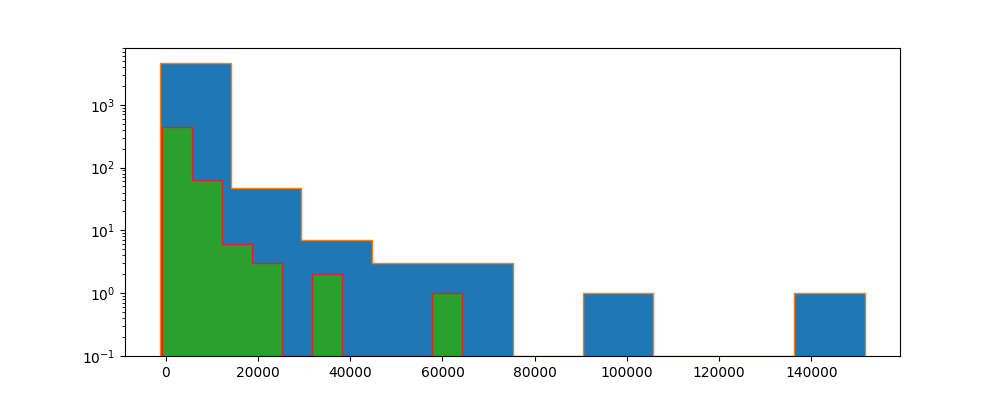

In [193]:
%matplot plt